In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from PIL import Image


In [18]:
model = models.resnet50(pretrained=True)


for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor(),                
    transforms.Normalize(                
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [21]:

dataset = datasets.ImageFolder("./Dataset", transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [22]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [24]:
num_epochs = 50

In [25]:
for epoch in range(num_epochs):
    model.train() 
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
 
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
       
        _, predicted_train = torch.max(outputs, 1)
        correct_train += (predicted_train == labels).sum().item()
        total_train += labels.size(0)
    
    average_train_loss = running_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
  
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            
            _, predicted_val = torch.max(outputs, 1)
            correct_val += (predicted_val == labels).sum().item()
            total_val += labels.size(0)
        
    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1/50, Train Loss: 0.6714, Train Accuracy: 61.94%
Epoch 1/50, Validation Loss: 0.8128, Validation Accuracy: 52.94%
Epoch 2/50, Train Loss: 0.5381, Train Accuracy: 70.15%
Epoch 2/50, Validation Loss: 0.7559, Validation Accuracy: 60.29%
Epoch 3/50, Train Loss: 0.4591, Train Accuracy: 78.73%
Epoch 3/50, Validation Loss: 0.6530, Validation Accuracy: 67.65%
Epoch 4/50, Train Loss: 0.4260, Train Accuracy: 79.85%
Epoch 4/50, Validation Loss: 0.5372, Validation Accuracy: 85.29%
Epoch 5/50, Train Loss: 0.3777, Train Accuracy: 84.70%
Epoch 5/50, Validation Loss: 0.5212, Validation Accuracy: 75.00%
Epoch 6/50, Train Loss: 0.3547, Train Accuracy: 85.07%
Epoch 6/50, Validation Loss: 0.4661, Validation Accuracy: 88.24%
Epoch 7/50, Train Loss: 0.3375, Train Accuracy: 83.96%
Epoch 7/50, Validation Loss: 0.4460, Validation Accuracy: 86.76%
Epoch 8/50, Train Loss: 0.3584, Train Accuracy: 86.94%
Epoch 8/50, Validation Loss: 0.4385, Validation Accuracy: 85.29%
Epoch 9/50, Train Loss: 0.3153, Train Ac

In [26]:

np.save('./models/ResNet50/train_losses.npy', np.array(train_losses))
np.save('./models/ResNet50/val_losses.npy', np.array(val_losses))
np.save('./models/ResNet50/train_accuracies.npy', np.array(train_accuracies))
np.save('./models/ResNet50/val_accuracies.npy', np.array(val_accuracies))


torch.save(model, './models/ResNet50/resnet50.pth')

In [27]:

loaded_model = torch.load('./models/ResNet50/resnet50.pth')

In [28]:
loaded_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())


Classification Report:
              precision    recall  f1-score   support

      Cancer       0.76      0.97      0.85        36
     Healthy       0.95      0.66      0.78        32

    accuracy                           0.82        68
   macro avg       0.86      0.81      0.82        68
weighted avg       0.85      0.82      0.82        68



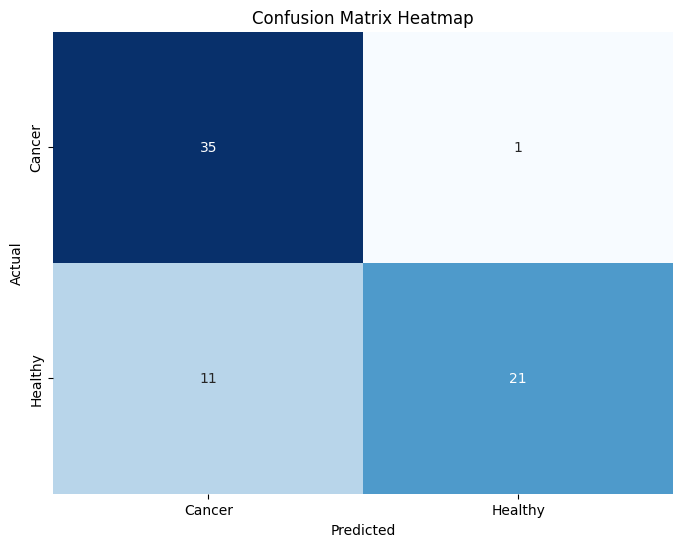

In [29]:
# Print classification report
print("\nClassification Report:")
print(classification_report(all_targets, np.array(all_preds), target_names=['Cancer', 'Healthy']))

# Plot confusion matrix heatmap
conf_matrix = confusion_matrix(all_targets, np.array(all_preds))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Cancer', 'Healthy'], yticklabels=['Cancer', 'Healthy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
train_losses = np.load('./models/ResNet50/train_losses.npy')
val_losses = np.load('./models/ResNet50/val_losses.npy')
train_accuracies = np.load('./models/ResNet50/train_accuracies.npy')
val_accuracies = np.load('./models/ResNet50/val_accuracies.npy')

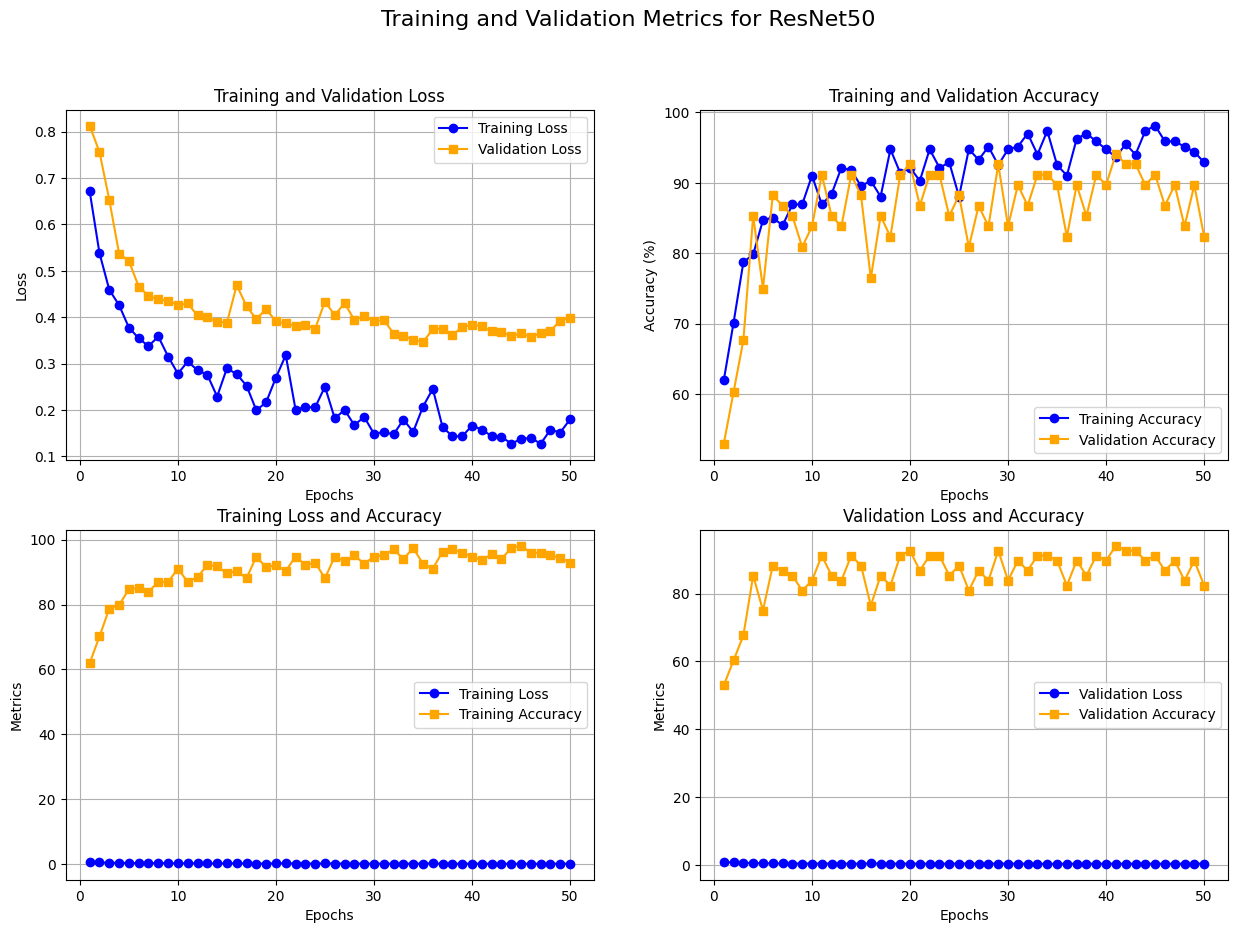

In [32]:

num_epochs = len(train_losses)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting Training and Validation Loss
axs[0, 0].plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', color='blue')
axs[0, 0].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s', color='orange')
axs[0, 0].set_title('Training and Validation Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plotting Training and Validation Accuracy
axs[0, 1].plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o', color='blue')
axs[0, 1].plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='s', color='orange')
axs[0, 1].set_title('Training and Validation Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy (%)')
axs[0, 1].legend()
axs[0, 1].grid(True)


axs[1, 0].plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', color='blue')
axs[1, 0].plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='s', color='orange')
axs[1, 0].set_title('Training Loss and Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Metrics')
axs[1, 0].legend()
axs[1, 0].grid(True)


axs[1, 1].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o', color='blue')
axs[1, 1].plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='s', color='orange')
axs[1, 1].set_title('Validation Loss and Accuracy')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Metrics')
axs[1, 1].legend()
axs[1, 1].grid(True)

fig.suptitle('Training and Validation Metrics for ResNet50', fontsize=16)

plt.show()

Image tensor shape: torch.Size([1, 3, 224, 224]), Image tensor dtype: torch.float32
Model output: tensor([[ 1.6111, -1.5629]])
Predicted index: 0


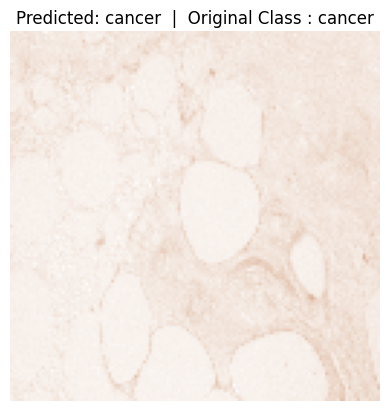

In [42]:
class_labels = ["cancer","healthy"]

def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')  
    image_tensor = transform(image)  
    image_tensor = image_tensor.unsqueeze(0).to(device) 

    print(f"Image tensor shape: {image_tensor.shape}, Image tensor dtype: {image_tensor.dtype}")

    with torch.no_grad():
        outputs = model(image_tensor)
        print(f"Model output: {outputs}")

        
        probabilities = torch.softmax(outputs, dim=1).squeeze()
        predicted = torch.argmax(probabilities).item()

        print(f"Predicted index: {predicted}")

        predicted_class = class_labels[predicted]

    return predicted_class, image

def plot_prediction(image_path):
    predicted_class, image = predict_image(image_path)

    if "cancer" in image_path.lower():
        original_class = "cancer"
    else:
        original_class = "healthy"

    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}  |  Original Class : {original_class}')
    plt.axis('off') 
    plt.show()


image_path = './Dataset/CANCER/10389 (14).png'
plot_prediction(image_path)